In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from matplotlib.gridspec import GridSpec
import torch
import fastmri
import os
import pywt

In [9]:
# read the files on my local computer

os.chdir('/Users/korat/Desktop/BEP/Programmeren/fastmri/brain/train')

fname = 'file_brain_AXFLAIR_200_6002425.h5'
data = h5py.File(fname, 'r')
data.keys()

<KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>

In [4]:
# Cell reads data on the hinton server 

# fname = '/home/svangurp/scratch/fastMRI/brain/train/file_brain_AXFLAIR_200_6002425.h5'
# data = h5py.File(fname, 'r')
# data.keys()

In [5]:
kspace_complex = data['kspace'][()] # in this one i don't split the coplex values
kspace = data['kspace'][()]
recon_rss= data['reconstruction_rss'][()]
print('shape k-space:',kspace.shape, '. shape reconstructed data',recon_rss.shape)

shape k-space: (16, 20, 640, 320) . shape reconstructed data (16, 320, 320)


In [16]:
# This function crates a mask with a fully sampled center and a random sample 

# the func assums that multi_coil_kspace has shape: (slices,coils,height, width)

def disk_mask_func(multi_coil_kspace, disk_radius):
    number_of_slices, number_of_coild,height, width = multi_coil_kspace.shape

    disk_mask = np.multiply(np.abs(np.random.randint(0,2,(height,width))),np.abs(np.random.randint(0,2,(height,width))))
    
    for i in range(height):
        for j in range(width):
            if np.sqrt(((i-(height/2))**2)+(j-(width/2))**2) <= disk_radius:
                disk_mask[i][j] = 1
                

    return disk_mask


#test of the function

# disk_mask = disk_mask_func(kspace_complex, disk_radius = 10)
# print('number of nonzero elements in the mask',np.count_nonzero(disk_mask))
# plt.imshow(disk_mask)
# plt.show()


# this function applies a mask to multicoil data, in this case the k-space and the mask have to be the same size
# the function does not combine the coils

# the func assums that multi_coil_kspace has shape: (slices,coils,eight, width)

def multicoil_masking_func(multi_coil_kspace, mask):
    
    number_of_slices, number_of_coils, height, width = multi_coil_kspace.shape
    masked_kspace_complex = np.zeros((multi_coil_kspace.shape), dtype = np.complex) 
    
    for slice in range(number_of_slices):
        for coil in range(number_of_coils):
            masked_kspace_complex[slice,coil,:,:] = np.multiply(multi_coil_kspace[slice,coil,:,:],mask)
    
    return masked_kspace_complex


# this function crops a np array along the last two dim's 
# kspace has to be of the form: number_of_slices, number_of_coild,height, width = kspace.shape
def center_crop_nparray(kspace, new_height, new_width):
    number_of_slices, number_of_coild,height, width = kspace.shape


    croped = kspace[:,:,int(height/2-new_height/2):int(height/2+new_height/2),int(width/2-new_width/2):int(width/2+new_width/2)]
    
    return croped


# test 
# croped = center_crop_nparray(kspace_complex, new_height = 320, new_width = 320)   
# croped.shape
# plt.imshow(np.abs(croped[0,0,:,:]), cmap ='gray')
# plt.show()

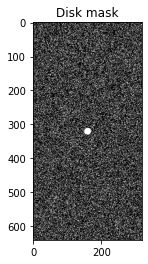

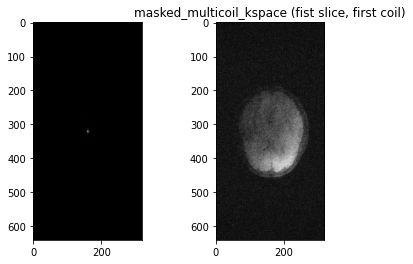

ValueError: too many values to unpack (expected 3)

In [26]:
# Creating a disk_mask 
disk_mask = disk_mask_func(kspace_complex, disk_radius = 10)
#plotting
plt.imshow((disk_mask), cmap ='gray')
plt.title('Disk mask')
plt.show()


# applying the mask to the multi coil data
masked_multicoil_kspace = multicoil_masking_func(kspace_complex,disk_mask)
#plotting
plt.subplot(1,2,1)
plt.imshow((np.abs(masked_multicoil_kspace[0,0,:,:])), cmap ='gray')
plt.subplot(1,2,2)
plt.imshow(np.abs(np.fft.fftshift(np.fft.ifft2(masked_multicoil_kspace[0,0,:,:]))), cmap ='gray')
plt.title('masked_multicoil_kspace (fist slice, first coil)')
plt.show()

# go to image space
masked_multicoil_image = np.fft.fftshift(np.fft.ifft2(masked_multicoil_kspace))

# center crop
masked_multicoil_cropped_image = center_crop_nparray(masked_multicoil_image, new_height = 320, new_width = 320)

# calculate the acceleration factor
original_nonzero = np.count_nonzero(kspace_complex)
print(original_nonzero)
masked_nonzero = np.count_nonzero(masked_multicoil_kspace)
print(masked_nonzero)
acceleration_factor = original_nonzero/masked_nonzero

# coil combination rss
masked_rss_croped_image = np.sqrt(np.sum(masked_multicoil_cropped_image**2,1))
#plotting
plt.imshow(abs(masked_rss_croped_image[0,:,:]),cmap = 'gray')
plt.title(f'Disk masked, acceleration factor = {round(acceleration_factor,2)}' )
plt.show()

